<a href="https://colab.research.google.com/github/VelasquezE/FourierOptics_assignments/blob/main/talleres/taller1/notebooks/taller01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importar librerías necesarias

In [4]:
import numpy as np
import cv2
import seaborn as sns
import os

import scipy.fft

from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt


# 1. Carga de imágenes

Se descarga la imagen cuadrada desde un repositorio de GitHub.

In [5]:
def get_image_path():
    url = "https://github.com/VelasquezE/FourierOptics_assignments/raw/d20d1cdfa4638c24c54bbebd68e6467576e05bbb/talleres/taller1/data/foto00_480_480.jpg"
    output_img = "imagen.png"

    if not os.path.exists(output_img):
        !wget -O {output_img} {url}

    img_path = os.path.abspath(output_img)
    print(f"Imagen descargada en: {img_path}")
    return img_path

In [6]:
base_path = get_image_path()

--2025-09-16 23:03:49--  https://github.com/VelasquezE/FourierOptics_assignments/raw/d20d1cdfa4638c24c54bbebd68e6467576e05bbb/talleres/taller1/data/foto00_480_480.jpg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/VelasquezE/FourierOptics_assignments/d20d1cdfa4638c24c54bbebd68e6467576e05bbb/talleres/taller1/data/foto00_480_480.jpg [following]
--2025-09-16 23:03:50--  https://raw.githubusercontent.com/VelasquezE/FourierOptics_assignments/d20d1cdfa4638c24c54bbebd68e6467576e05bbb/talleres/taller1/data/foto00_480_480.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90809 (89K) [image/jpeg]
Sav

# 2. Procesamiento de la imagen

In [8]:
img = cv2.imread(base_path, cv2.IMREAD_GRAYSCALE)

(np.float64(-0.5), np.float64(479.5), np.float64(479.5), np.float64(-0.5))

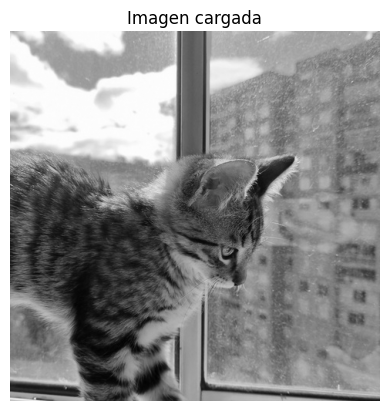

In [12]:
plt.imshow(img, cmap = "gray")
plt.title(f"Imagen cargada")
plt.axis("off")

### 2.1. Muestreo

In [13]:
def take_sample(img: np.ndarray, sample_size: int) -> np.ndarray:
    """
    Takes a sample of pixels of a picture by slicing the picture
    array every sample_size rows and columns.

    Parameters:
    - img (np.darray): 2d array of the picture.
    - sample_size (int): given sample size.

    Returns:
        sampled array

    """
    return img[::sample_size, ::sample_size]

In [16]:
sample = 3
img_sample = take_sample(img, sample)

(np.float64(-0.5), np.float64(159.5), np.float64(159.5), np.float64(-0.5))

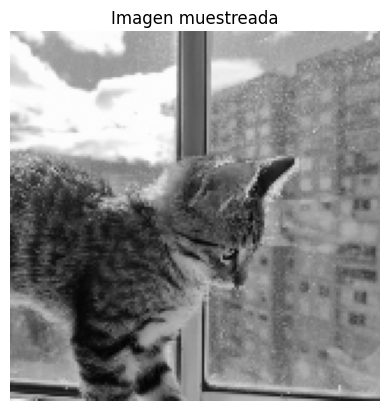

In [17]:
plt.imshow(img_sample, cmap = "gray")
plt.title(f"Imagen muestreada")
plt.axis("off")

# 3. Transformada de Fourier

In [18]:
fourier_transform = scipy.fft.fft2(img_sample)
shifted_spectrum = scipy.fft.fftshift(fourier_transform)

visualization = np.abs(shifted_spectrum)

(np.float64(-0.5), np.float64(159.5), np.float64(159.5), np.float64(-0.5))

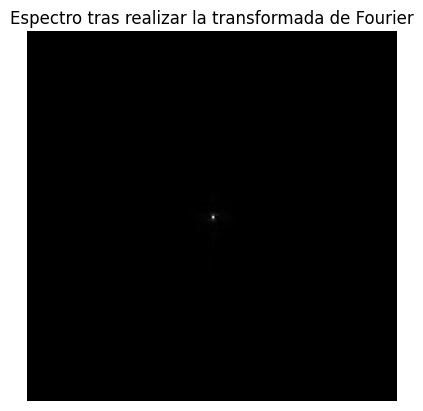

In [19]:
plt.imshow(visualization, cmap = "gray")
plt.title(f"Espectro tras realizar la transformada de Fourier")
plt.axis("off")